In [2]:
import torch
from transformers import BertTokenizer, BertModel
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

In [3]:
import torch
from transformers import BertTokenizer, BertModel

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model =     BertModel.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:

# Tokenize the sentences
all_train_data = pd.read_csv('data/train_data_full.csv')
balanced_train_data = all_train_data #[:50]
X_train = balanced_train_data['tweet']
Y_train__ = balanced_train_data['value']


In [5]:

sentences = X_train #['we live in a beautiful world',"This is sentence 1", "This is sentence 2",'Hello, my name is John Smith',"dear amazing world I'm so happy"]
tokenized_sentences = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

# Pad the tokenized sentences so that they have the same length
max_length = max(len(x) for x in tokenized_sentences)
padded_sentences = [x + [0] * (max_length - len(x)) for x in tokenized_sentences]

# Convert the tokenized sentences to tensors
input_ids = torch.tensor(padded_sentences)

# Use the BERT model to encode the sentences into vectors
with torch.no_grad():
    encoded_sentences = model(input_ids)[0]

# The encoded sentences will be a tensor with shape (batch_size, sequence_length, hidden_size)
print(encoded_sentences.shape)


torch.Size([7002, 81, 768])


In [6]:
all_sentences = []  # list to store the pooled vectors for each sentence

for output in encoded_sentences:  # loop over each output tensor
    sentence_vector = output.max(dim=0)[0]  # apply max pooling
    all_sentences.append(sentence_vector)  # add the pooled vector to the list

all_sentences = torch.stack(all_sentences)  # stack the sentence vectors into a single tensor

7002

In [7]:
sentences = len(all_sentences)
# Convert the input tensor to a numpy array
encoded_sentences_np = all_sentences.numpy()

# Reshape the input array to [num_sentences * sequence_length, embedding_dim]
encoded_sentences_np = encoded_sentences_np.reshape(-1, 768)

# Apply PCA to reduce the number of dimensions from 768 to 256
pca = PCA(n_components=40)
reduced_encoded_sentences = pca.fit_transform(encoded_sentences_np)

# Reshape the reduced input array back to [num_sentences, sequence_length, reduced_embedding_dim]
reduced_encoded_sentences = reduced_encoded_sentences.reshape(sentences, 40)


In [8]:
reduced_encoded_sentences_tensor = torch.tensor(reduced_encoded_sentences)
mean = torch.mean(reduced_encoded_sentences_tensor, dim=1, keepdim=True)
std = torch.std(reduced_encoded_sentences_tensor, dim=1, keepdim=True)

# Normalize the tensor by subtracting the mean and dividing by the standard deviation
normalized_encoded_sentences_tensor = (reduced_encoded_sentences_tensor - mean) / (std + 1e-8)

In [9]:
normalized_encoded_sentences_tensor

tensor([[ 3.3968,  0.2750,  0.6959,  ...,  0.1585, -0.8450, -0.7972],
        [ 3.3968,  0.2749,  0.6959,  ...,  0.1586, -0.8450, -0.7972],
        [ 3.3968,  0.2749,  0.6959,  ...,  0.1586, -0.8450, -0.7972],
        ...,
        [-3.3123,  1.4011,  0.6510,  ...,  1.3697,  0.0723,  0.1357],
        [-3.3123,  1.4011,  0.6510,  ...,  1.3697,  0.0723,  0.1357],
        [-3.3123,  1.4011,  0.6510,  ...,  1.3697,  0.0723,  0.1357]])

In [10]:
Y_train = [[label/5] for label in Y_train__]
# Y_train = [[label] for label in Y_train__]
# train_combined['value'] = (train_combined['value']/5)

In [11]:
all_sentences2 = normalized_encoded_sentences_tensor

for feature in ['Q21','Q22','Q23','Q24','Q25','Q26','Q28','Q29','Q30','Q31']:
    one_hot = pd.get_dummies(pd.DataFrame(balanced_train_data[feature]))
    one_hot_list = one_hot.values.tolist()

    features_list=[]
    for i,vector in enumerate(all_sentences2):  # loop over each output tensor
        new_value = torch.tensor(one_hot_list[i])
        new_vector = torch.cat((vector, new_value))

        features_list.append(new_vector)  # add the pooled vector to the list
#         print(features_list)
    all_features = torch.stack(features_list) 
    all_sentences2 = all_features

In [12]:
print(len(all_features[0]))
print(len(all_features))

92
7002


In [13]:
all_features[0]

tensor([ 3.3968,  0.2750,  0.6959,  0.6651, -1.5418,  0.1997,  0.4876, -0.5159,
        -0.5910,  0.8447, -0.9489, -0.5913,  0.9347, -0.9080,  1.1275,  1.0375,
         0.3386, -2.2018,  0.2357,  0.1335,  0.3113,  0.3643, -1.8224,  0.5324,
        -0.6485, -0.2913,  0.8555,  0.0282, -0.4115,  0.2447, -0.8901, -1.3190,
        -0.6055,  0.8564, -0.4408,  0.4448,  1.2015,  0.1585, -0.8450, -0.7972,
         0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.0000])

In [17]:
# list_of_lists=['Q21','Q22','Q23','Q24','Q25','Q26','Q28','Q29','Q30','Q31']

# for text_list in list_of_lists:
#     new_list = mapping_list(balanced_train_data[text_list])
    
#     for _ in range(1):
#         features_list=[]

#         for i,vector in enumerate(all_sentences):  # loop over each output tensor
#             new_value = torch.tensor(new_list[i])
#             new_vector = torch.cat((vector, new_value))

#             features_list.append(new_vector)  # add the pooled vector to the list

#         all_features = torch.stack(features_list)  # stack the sentence vectors into a single tensor
#         all_sentences2 = all_features
# # change o one hot

[[0, '31-40'], [1, '51-60'], [2, 'Above 60 years old'], [3, '41-50'], [4, '26-30'], [5, '18-25']]
[[0, 'Male'], [1, 'Female']]
[[0, '8th Up to 12th grade, no diploma'], [1, 'Associate degree'], [2, "Master's degree"], [3, 'High school graduate with diploma'], [4, "Bachelor's degree"]]
[[0, 'Employee'], [1, 'Out of work and looking for work'], [2, 'Unable to work'], [3, 'Self-employed'], [4, 'A homemaker']]
[[0, 'Agree'], [1, 'Strongly agree'], [2, 'Neither agree nor disagree'], [3, 'Disagree']]
[[0, 'Agree'], [1, 'Neither agree nor disagree'], [2, 'Disagree'], [3, 'Strongly Disagree'], [4, 'Strongly agree']]
[[0, 'Agree'], [1, 'Neither agree nor disagree'], [2, 'Disagree'], [3, 'Strongly Disagree'], [4, 'Strongly agree']]
[[0, 'Agree'], [1, 'Disagree'], [2, 'Strongly Disagree'], [3, 'Strongly agree'], [4, 'Neither agree nor disagree']]
[[0, 'Strongly agree'], [1, 'Agree'], [2, 'Neither agree nor disagree'], [3, 'Disagree']]
[[0, 'Very concerned'], [1, 'Somewhat concerned'], [2, 'A litt

In [14]:
# Define the fully connected model
fc_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=30, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
# fc_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['Precision','accuracy','TruePositives','TrueNegatives','FalsePositives','FalseNegatives'])

#  binary
fc_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','MeanSquaredError','RootMeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError','MeanSquaredLogarithmicError','CosineSimilarity','LogCoshError'])



In [15]:
len(all_features[0])

92

In [16]:
# Convert the PyTorch tensor to a Numpy array
# all_sentences = all_features
# x_train = all_sentences.detach().numpy()
x_train = all_features.detach().numpy()

# Convert the Python list to a Numpy array
# Y_train=[0,1,1,0,0]
y_train = np.array(Y_train)

# Fit the model using the Numpy arrays
fc_model.fit(x_train, y_train, epochs=150, batch_size=32)


Epoch 1/150
219/219 [==============================] - 1s 1ms/step - loss: 0.0580 - accuracy: 0.1030 - mean_squared_error: 0.0580 - root_mean_squared_error: 0.2409 - mean_absolute_error: 0.1950 - mean_absolute_percentage_error: 44.5257 - mean_squared_logarithmic_error: 0.0234 - cosine_similarity: 1.0000 - logcosh: 0.0284
Epoch 2/150
219/219 [==============================] - 0s 1ms/step - loss: 0.0532 - accuracy: 0.1105 - mean_squared_error: 0.0532 - root_mean_squared_error: 0.2307 - mean_absolute_error: 0.1868 - mean_absolute_percentage_error: 43.3732 - mean_squared_logarithmic_error: 0.0215 - cosine_similarity: 1.0000 - logcosh: 0.0261
Epoch 3/150
219/219 [==============================] - 0s 1ms/step - loss: 0.0526 - accuracy: 0.1107 - mean_squared_error: 0.0526 - root_mean_squared_error: 0.2293 - mean_absolute_error: 0.1855 - mean_absolute_percentage_error: 43.2636 - mean_squared_logarithmic_error: 0.0213 - cosine_similarity: 1.0000 - logcosh: 0.0258
Epoch 4/150
219/219 [==========

219/219 [==============================] - 0s 1ms/step - loss: 0.0410 - accuracy: 0.1085 - mean_squared_error: 0.0410 - root_mean_squared_error: 0.2024 - mean_absolute_error: 0.1625 - mean_absolute_percentage_error: 37.0755 - mean_squared_logarithmic_error: 0.0166 - cosine_similarity: 1.0000 - logcosh: 0.0201
Epoch 27/150
219/219 [==============================] - 0s 1ms/step - loss: 0.0404 - accuracy: 0.1093 - mean_squared_error: 0.0404 - root_mean_squared_error: 0.2011 - mean_absolute_error: 0.1618 - mean_absolute_percentage_error: 36.7291 - mean_squared_logarithmic_error: 0.0164 - cosine_similarity: 1.0000 - logcosh: 0.0199
Epoch 28/150
219/219 [==============================] - 0s 1ms/step - loss: 0.0402 - accuracy: 0.1085 - mean_squared_error: 0.0402 - root_mean_squared_error: 0.2006 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 36.5349 - mean_squared_logarithmic_error: 0.0163 - cosine_similarity: 1.0000 - logcosh: 0.0198
Epoch 29/150
219/219 [===================

219/219 [==============================] - 0s 1ms/step - loss: 0.0322 - accuracy: 0.1078 - mean_squared_error: 0.0322 - root_mean_squared_error: 0.1794 - mean_absolute_error: 0.1440 - mean_absolute_percentage_error: 31.3615 - mean_squared_logarithmic_error: 0.0130 - cosine_similarity: 1.0000 - logcosh: 0.0159
Epoch 52/150
219/219 [==============================] - 0s 1ms/step - loss: 0.0315 - accuracy: 0.1091 - mean_squared_error: 0.0315 - root_mean_squared_error: 0.1774 - mean_absolute_error: 0.1421 - mean_absolute_percentage_error: 31.1057 - mean_squared_logarithmic_error: 0.0127 - cosine_similarity: 1.0000 - logcosh: 0.0155
Epoch 53/150
219/219 [==============================] - 0s 1ms/step - loss: 0.0311 - accuracy: 0.1077 - mean_squared_error: 0.0311 - root_mean_squared_error: 0.1763 - mean_absolute_error: 0.1417 - mean_absolute_percentage_error: 30.7971 - mean_squared_logarithmic_error: 0.0125 - cosine_similarity: 1.0000 - logcosh: 0.0153
Epoch 54/150
219/219 [===================

219/219 [==============================] - 0s 1ms/step - loss: 0.0285 - accuracy: 0.1080 - mean_squared_error: 0.0285 - root_mean_squared_error: 0.1690 - mean_absolute_error: 0.1357 - mean_absolute_percentage_error: 29.0968 - mean_squared_logarithmic_error: 0.0115 - cosine_similarity: 1.0000 - logcosh: 0.0141
Epoch 76/150
219/219 [==============================] - 0s 1ms/step - loss: 0.0283 - accuracy: 0.1088 - mean_squared_error: 0.0283 - root_mean_squared_error: 0.1683 - mean_absolute_error: 0.1352 - mean_absolute_percentage_error: 29.0639 - mean_squared_logarithmic_error: 0.0114 - cosine_similarity: 1.0000 - logcosh: 0.0140
Epoch 77/150
219/219 [==============================] - 0s 1ms/step - loss: 0.0286 - accuracy: 0.1093 - mean_squared_error: 0.0286 - root_mean_squared_error: 0.1691 - mean_absolute_error: 0.1358 - mean_absolute_percentage_error: 29.1662 - mean_squared_logarithmic_error: 0.0115 - cosine_similarity: 1.0000 - logcosh: 0.0141
Epoch 78/150
219/219 [===================

219/219 [==============================] - 0s 1ms/step - loss: 0.0259 - accuracy: 0.1093 - mean_squared_error: 0.0259 - root_mean_squared_error: 0.1609 - mean_absolute_error: 0.1282 - mean_absolute_percentage_error: 27.4400 - mean_squared_logarithmic_error: 0.0104 - cosine_similarity: 1.0000 - logcosh: 0.0128
Epoch 101/150
219/219 [==============================] - 0s 1ms/step - loss: 0.0259 - accuracy: 0.1088 - mean_squared_error: 0.0259 - root_mean_squared_error: 0.1610 - mean_absolute_error: 0.1284 - mean_absolute_percentage_error: 27.2049 - mean_squared_logarithmic_error: 0.0104 - cosine_similarity: 1.0000 - logcosh: 0.0128
Epoch 102/150
219/219 [==============================] - 0s 1ms/step - loss: 0.0262 - accuracy: 0.1083 - mean_squared_error: 0.0262 - root_mean_squared_error: 0.1618 - mean_absolute_error: 0.1295 - mean_absolute_percentage_error: 27.5828 - mean_squared_logarithmic_error: 0.0105 - cosine_similarity: 1.0000 - logcosh: 0.0129
Epoch 103/150
219/219 [================

219/219 [==============================] - 0s 1ms/step - loss: 0.0253 - accuracy: 0.1093 - mean_squared_error: 0.0253 - root_mean_squared_error: 0.1590 - mean_absolute_error: 0.1266 - mean_absolute_percentage_error: 26.9542 - mean_squared_logarithmic_error: 0.0102 - cosine_similarity: 1.0000 - logcosh: 0.0125
Epoch 126/150
219/219 [==============================] - 0s 1ms/step - loss: 0.0253 - accuracy: 0.1083 - mean_squared_error: 0.0253 - root_mean_squared_error: 0.1589 - mean_absolute_error: 0.1265 - mean_absolute_percentage_error: 26.8907 - mean_squared_logarithmic_error: 0.0101 - cosine_similarity: 1.0000 - logcosh: 0.0125
Epoch 127/150
219/219 [==============================] - 0s 1ms/step - loss: 0.0244 - accuracy: 0.1084 - mean_squared_error: 0.0244 - root_mean_squared_error: 0.1561 - mean_absolute_error: 0.1241 - mean_absolute_percentage_error: 26.4617 - mean_squared_logarithmic_error: 0.0098 - cosine_similarity: 1.0000 - logcosh: 0.0120
Epoch 128/150
219/219 [================

219/219 [==============================] - 0s 1ms/step - loss: 0.0240 - accuracy: 0.1098 - mean_squared_error: 0.0240 - root_mean_squared_error: 0.1551 - mean_absolute_error: 0.1230 - mean_absolute_percentage_error: 26.1339 - mean_squared_logarithmic_error: 0.0097 - cosine_similarity: 1.0000 - logcosh: 0.0119


In [53]:
len(x_train[0])

92

In [22]:
'''# Define a list of test sentences
test_sentences = ['This is a positive sentence', 'This is a negative sentence']

# Tokenize and encode the test sentences
test_input_ids = [tokenizer.encode(sent, add_special_tokens=True) for sent in test_sentences]

# Pad the test input ids
test_input_ids = tf.keras.preprocessing.sequence.pad_sequences(test_input_ids, maxlen=max_length, dtype='long', value=0, truncating='post', padding='post')

# Convert the test input ids to tensors
test_input_ids = torch.tensor(test_input_ids)

# Generate the contextualized embeddings
output = model(test_input_ids)
'''
# # Extract the first element of the output tuple
# vectors = output[0]
# print (vectors)
# # Predict the label of each test sentence

vectors = x_train 
predictions = fc_model.predict(vectors)
listt = []
for i in range(len(vectors)):
    listt.append((predictions[i],y_train[i]))

    
# Print the predictions
for i in range(len(vectors)//100):
#     print(f'Sentence: {vectors[i]}')
    print(f'Prediction: {predictions[i]}')
    print(f'Label: {y_train[i]}')

    


Prediction: [0.7303353]
Label: [0.8]
Prediction: [0.69954896]
Label: [0.6]
Prediction: [0.8920794]
Label: [1.]
Prediction: [0.79388595]
Label: [0.8]
Prediction: [0.34381086]
Label: [0.4]
Prediction: [0.7174011]
Label: [0.8]
Prediction: [0.45851606]
Label: [0.2]
Prediction: [0.5623201]
Label: [0.6]
Prediction: [0.7629971]
Label: [1.]
Prediction: [0.5213575]
Label: [0.4]
Prediction: [0.5529085]
Label: [0.6]
Prediction: [0.60488796]
Label: [0.4]
Prediction: [0.78214985]
Label: [0.8]
Prediction: [0.39948225]
Label: [0.4]
Prediction: [0.74435097]
Label: [0.6]
Prediction: [0.5213575]
Label: [0.2]
Prediction: [0.632048]
Label: [0.6]
Prediction: [0.5625036]
Label: [0.8]
Prediction: [0.4995121]
Label: [0.4]
Prediction: [0.66970396]
Label: [0.8]
Prediction: [0.7127059]
Label: [0.6]
Prediction: [0.32304662]
Label: [0.2]
Prediction: [0.38905847]
Label: [0.4]
Prediction: [0.69063747]
Label: [0.6]
Prediction: [0.726806]
Label: [0.8]
Prediction: [0.64968395]
Label: [0.8]
Prediction: [0.5961367]
Label

In [24]:
df = pd.DataFrame(listt) 
    
# saving the dataframe 
df.to_csv('resulats_01.csv') 

# with open('resulats_01', 'w') as f:
      
#     # using csv.writer method from CSV package
#     write = csv.writer(f)
      
# #     write.writerow(fields)
#     write.writerows(listt)

In [18]:
print(min(predictions))
print(max(predictions))

[0.18303576]
[0.948789]


In [25]:

# Tokenize the sentences
all_test_data = pd.read_csv('data/test_data_full.csv')
balanced_test_data = all_test_data #[:50]
X_test = balanced_test_data['tweet']
Y_test__ = balanced_test_data['value']



sentences_test = X_test 
tokenized_sentences_test = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences_test]

# Pad the tokenized sentences so that they have the same length
max_length = max(len(x) for x in tokenized_sentences)  # of the train
padded_sentences_test = [x + [0] * (max_length - len(x)) for x in tokenized_sentences_test]

# Convert the tokenized sentences to tensors
input_ids_test = torch.tensor(padded_sentences_test)

# Use the BERT model to encode the sentences into vectors
with torch.no_grad():
    encoded_sentences_test = model(input_ids_test)[0]

# The encoded sentences will be a tensor with shape (batch_size, sequence_length, hidden_size)
print(encoded_sentences_test.shape)


all_sentences_test = []  # list to store the pooled vectors for each sentence

for output in encoded_sentences_test:  # loop over each output tensor
    sentence_vector = output.max(dim=0)[0]  # apply max pooling
    all_sentences_test.append(sentence_vector)  # add the pooled vector to the list

all_sentences_test = torch.stack(all_sentences_test)  # stack the sentence vectors into a single tensor



sentences_test = len(all_sentences_test)
# Convert the input tensor to a numpy array
encoded_sentences_np_test = all_sentences_test.numpy()

# Reshape the input array to [num_sentences * sequence_length, embedding_dim]
encoded_sentences_np_test = encoded_sentences_np_test.reshape(-1, 768)

# Apply PCA to reduce the number of dimensions from 768 to 256
pca_test = PCA(n_components=40)
reduced_encoded_sentences_test = pca_test.fit_transform(encoded_sentences_np_test)

# Reshape the reduced input array back to [num_sentences, sequence_length, reduced_embedding_dim]
reduced_encoded_sentences_test = reduced_encoded_sentences_test.reshape(sentences_test, 40)



reduced_encoded_sentences_tensor_test = torch.tensor(reduced_encoded_sentences_test)
mean_test = torch.mean(reduced_encoded_sentences_tensor_test, dim=1, keepdim=True)
std_test = torch.std(reduced_encoded_sentences_tensor_test, dim=1, keepdim=True)

# Normalize the tensor by subtracting the mean and dividing by the standard deviation
normalized_encoded_sentences_tensor_test = (reduced_encoded_sentences_tensor_test - mean_test) / (std_test + 1e-8)

Y_test = [[label/5] for label in Y_test__]

all_sentences2_test = normalized_encoded_sentences_tensor_test

for feature in ['Q21','Q22','Q23','Q24','Q25','Q26','Q28','Q29','Q30','Q31']:
    one_hot = pd.get_dummies(pd.DataFrame(balanced_test_data[feature]))
    one_hot_list = one_hot.values.tolist()

    features_list=[]
    for i,vector in enumerate(all_sentences2_test):  # loop over each output tensor
        new_value = torch.tensor(one_hot_list[i])
        new_vector = torch.cat((vector, new_value))

        features_list.append(new_vector)  # add the pooled vector to the list
#         print(features_list)
    all_features = torch.stack(features_list) 
    all_sentences2_test = all_features

torch.Size([2424, 81, 768])


In [28]:
# fc_model.fit(x_train, y_train, epochs=150, batch_size=32)

X_test = all_sentences2_test.detach().numpy()

# Convert the Python list to a Numpy array
# Y_train=[0,1,1,0,0]
# y_train = np.array(Y_train)

vectors = X_test 
predictions = fc_model.predict(vectors)

list_test = []
for i in range(len(vectors)):
    list_test.append((predictions[i],Y_test[i]))


# Print the predictions
for i in range(len(vectors)//100):
#     print(f'Sentence: {vectors[i]}')
#     print(f'Prediction: {predictions[i]}')
#     print(f'Label: {y_test[i]}')
    print(predictions[i] - Y_test[i])


[-0.12236123]
[0.25533859]
[-0.08487432]
[-0.08725553]
[-0.06188705]
[0.04842403]
[0.10864892]
[0.10610071]
[0.54197614]
[-0.25937283]
[0.26101921]
[-0.23700345]
[0.59749215]
[0.16159453]
[-0.23850542]
[0.00540372]
[0.07801393]
[0.13080802]
[-0.11305115]
[-0.08663175]
[0.04930969]
[-0.18246738]
[-0.04665939]
[0.02194538]


In [29]:
df = pd.DataFrame(list_test) 
    
# saving the dataframe 
df.to_csv('resulats__test_01.csv') 


In [1]:
print(len(balanced_test_data))
print(len(reduced_encoded_sentences_tensor_test))


NameError: name 'balanced_test_data' is not defined

In [20]:

vectors = all_sentences2_test.detach().numpy() 
predictions = fc_model.predict(vectors)

result=[]
# Print the predictions
for i in range(len(vectors)):
    a = [predictions[i],Y_test[i]]
    result.append(a)



In [22]:
with open('initia_data', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(result)
    write.writerows(rows)



[[array([0.60020196], dtype=float32), [0.8]],
 [array([0.4673745], dtype=float32), [0.4]],
 [array([0.82722473], dtype=float32), [0.8]],
 [array([0.6111475], dtype=float32), [0.8]],
 [array([0.2961433], dtype=float32), [0.4]],
 [array([0.58341855], dtype=float32), [0.6]],
 [array([0.6383685], dtype=float32), [0.6]],
 [array([0.6747683], dtype=float32), [0.4]],
 [array([0.49052528], dtype=float32), [0.2]],
 [array([0.7602731], dtype=float32), [1.0]],
 [array([0.6802073], dtype=float32), [0.4]],
 [array([0.7750312], dtype=float32), [1.0]],
 [array([0.82201916], dtype=float32), [0.2]],
 [array([0.7134541], dtype=float32), [0.6]],
 [array([0.73252594], dtype=float32), [1.0]],
 [array([0.51365376], dtype=float32), [0.6]],
 [array([0.4614176], dtype=float32), [0.4]],
 [array([0.6296742], dtype=float32), [0.6]],
 [array([0.5793135], dtype=float32), [0.6]],
 [array([0.50952494], dtype=float32), [0.6]],
 [array([0.6170609], dtype=float32), [0.6]],
 [array([0.35344905], dtype=float32), [0.6]],
 

In [23]:
summ=0
countt=0
for i in result:
    countt+=1
    if abs(i[0] - i[1]) > 0.3:
#         print(i)
        summ+=1
print(summ)
print(countt)

478
2424


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, n_informative=2,
                       random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, y)
RandomForestRegressor(...)
print(regr.predict([[0, 0, 0, 0]]))



[-8.32987858]


In [14]:
X = all_sentences
y=Y_train
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, y)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(max_depth=2, random_state=0)

In [15]:
regr.score(X, y)

0.03658254827410501

In [51]:
regr.score(X, y)

0.01286463621178946

In [18]:
b=regr.predict(X)
print(max(b))
print(min(b))

0.6374053953892164
0.4642081792264311


In [2]:
balanced_train_data = pd.read_csv('data/train_data.csv')


In [6]:
balanced_train_data['value'][:10]

0    4.0
1    3.0
2    5.0
3    4.0
4    2.0
5    4.0
6    1.0
7    3.0
8    5.0
9    2.0
Name: value, dtype: float64

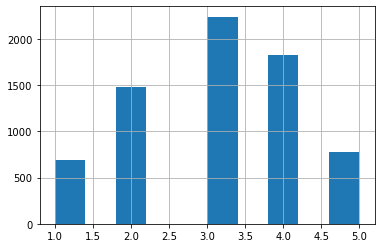

In [7]:
hist = pd.Series(balanced_train_data['value']).hist()


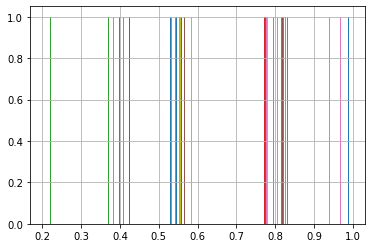

In [21]:
hist = pd.Series(Y_train).hist()